# Tasks

1. Dataset
  1. Download PGM Dataset ✅
  2. Seperate Train, Val and Test ✅
  3. Trim ✅
  4. Load into Pytorch ✅
    1. Create Dataset Class ✅
    2. Structure image for easy access ✅
    3. Data Augumentation if required
2. ViT
  1. Choose on what to set as labels
  2. Tranformer architecture
    1. Patch embedding
    2. Positional encoding
    4. Class tokens
    5. Tranformer Layer
    6. Multihead Attention
    7. MLP Layer
  3. Experiment with attributes
3. Training
  1. Add Adam optimizer
  2. Implement cross entropy





# Notes

## Method 1

Train on the matrices such that the ViT predicts the relation between them and then apply those transformation on choices using OpenCV to find the one with closest similarity


## Method 2

Split the choices and add it to the patterns and train for the similarities.
Similar to https://arxiv.org/pdf/1911.05990v1

# 1. Setup

In [ ]:
%%capture
!pip install umap-learn
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "gdrive/My Drive/"

/content/gdrive/My Drive


In [ ]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from IPython import display
from pathlib import Path
import os
from enum import Enum
from typing import Tuple, List

# import standard PyTorch modules
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

import umap
import datasets
import zipfile
import re
import albumentations

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
from tqdm.notebook import tqdm
from collections import Counter

Running on torch.__version__ =  2.5.0+cu121


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 2. Dataset

In [ ]:
TRAIN_DATASET_DIR = "./dataset/neutral_trim/train/"
VAL_DATASET_DIR = "./dataset/neutral_trim/val/"
TEST_DATASET_DIR = "./dataset/neutral_trim/test/"

## 2.1. Preview a sample of PGM

In [ ]:
data = np.load(TRAIN_DATASET_DIR+"PGM_neutral_train_10.npz")
images = data["image"].reshape(16, 160, 160)
ans = data["target"]

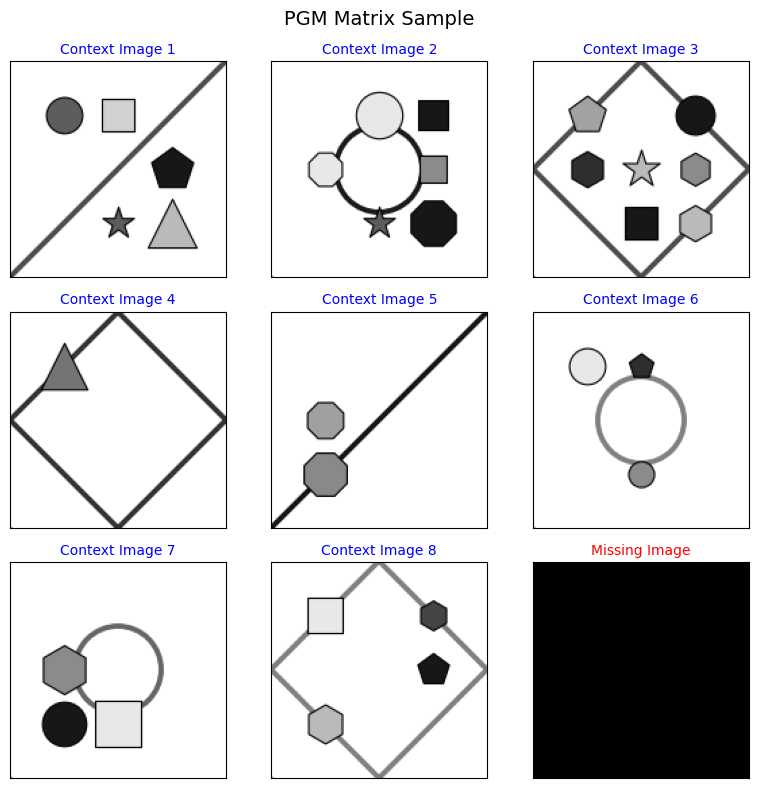

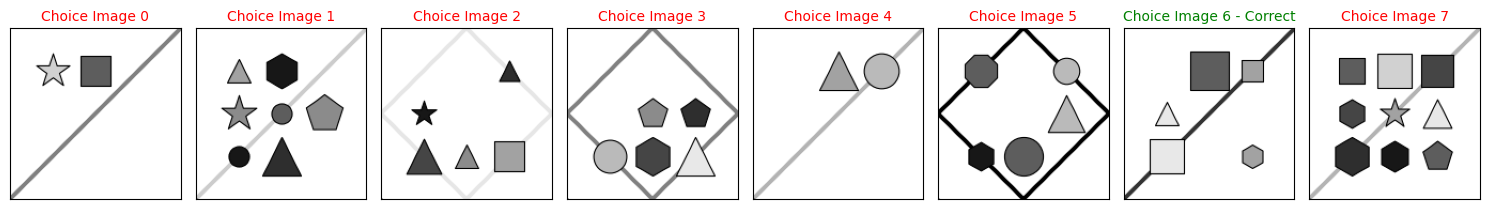

In [ ]:
def plot_matrices(images, ans):

    # Add a new image at the 8th index (You can modify 'new_image' as needed)
    missing_image = np.zeros((160, 160))  # Example new image (randomly generated here)
    images_to_plot = np.append(images[:8], [missing_image], axis=0)  # Insert the new image at 8th position
    images_to_plot = np.append(images_to_plot, images[8:], axis=0)

    # Plot first 8 images in a 4x2 grid with the first heading
    fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
    fig1.suptitle("PGM Matrix Sample", fontsize=14)


    for i, ax in enumerate(axes1.flat):
        ax.imshow(images_to_plot[i], cmap='gray')
        if i == 8:
            ax.set_title("Missing Image", fontsize=10, color="red")
        else:
          ax.set_title(f"Context Image {i+1}", fontsize=10, color="blue")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()

    # Plot first 8 images in a 4x2 grid with the first heading
    fig2, axes2 = plt.subplots(1, 8, figsize=(15, 15))

    for i, ax in enumerate(axes2.flat):
        ax.imshow(images_to_plot[i+9], cmap='gray')
        if i == ans:
            ax.set_title(f"Choice Image {i} - Correct", fontsize=10, color="green")
        else:
            ax.set_title(f"Choice Image {i}", fontsize=10, color="red")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_matrices(images, ans)

## 2.2. PGM Dataset Class

In [ ]:
class PgmDataset(Dataset):
    FILEPATH_PATTERN = re.compile(r"PGM_([\w.]+)_(\w+)_(\d+).npz")

    def __init__(
            self,
            data_dir: str = '.',
            double_downscale_images: bool = False):
        self.filenames = self._list_filenames(data_dir)
        self.reshape_images = True
        self.double_downscale_images = double_downscale_images

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        data = np.load(self.filenames[idx])
        images, target, meta_matrix, meta_target = data['image'], data['target'], data['relation_structure_encoded'], data['meta_target']
        if self.reshape_images:
            h, w, c = images.shape
            images = np.ascontiguousarray(images.reshape(c, h, w))
        if self.double_downscale_images:
            images = images[:, ::2, ::2]
        images = images.astype('float32') / 255.0
        images = self._to_tensor(images)
        context_images = images[:8]
        choice_images = images[8:]
        target = torch.tensor(target)
        meta_matrix = torch.tensor(meta_matrix)
        meta_target = torch.tensor(meta_target)
        return context_images,choice_images, target, meta_matrix, meta_target

    @staticmethod
    def _to_tensor(images: np.array) -> torch.Tensor:
        return torch.tensor(images)

    def _list_filenames(self, data_dir: str):
        return [
            os.path.join(data_dir, f)
            for f in os.listdir(data_dir)
        ]


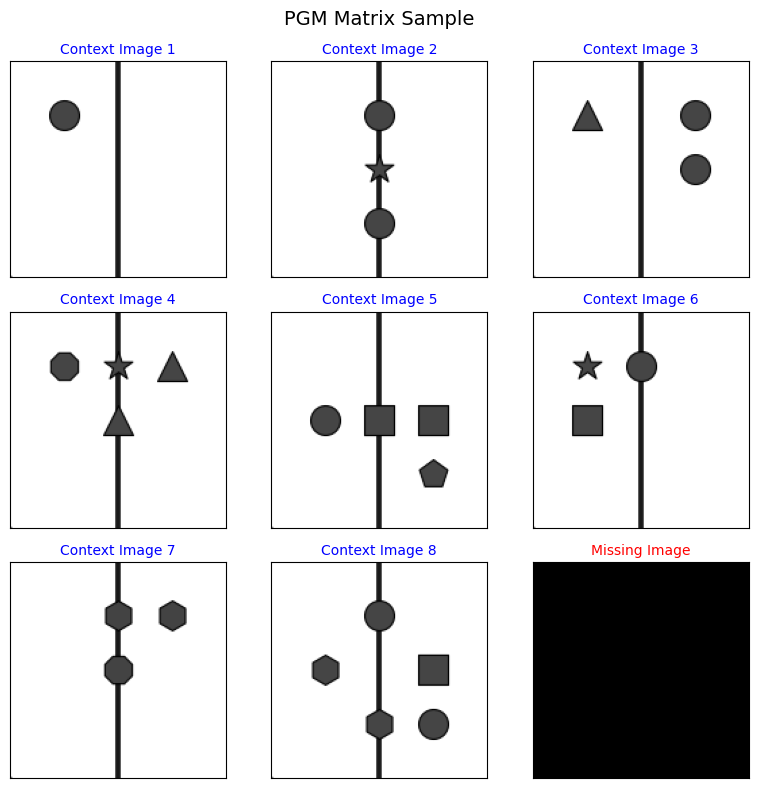

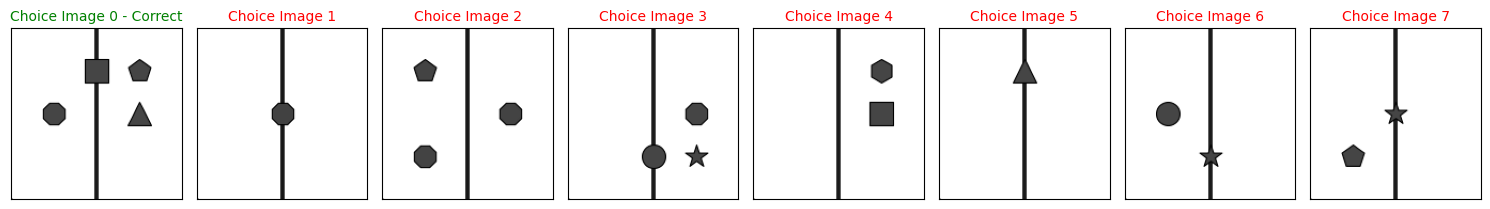

torch.Size([160, 160])


In [ ]:
# Create instances of the PgmDataset for Train, Val and Test
pgm_dataset_train = PgmDataset(
    data_dir=TRAIN_DATASET_DIR,
    double_downscale_images=False
)

pgm_dataset_val = PgmDataset(
    data_dir=VAL_DATASET_DIR,
    double_downscale_images=False
)

pgm_dataset_test = PgmDataset(
    data_dir=TEST_DATASET_DIR,
    double_downscale_images=False
)

# plot a sample from train dataset
context_images, choice_images, target, meta_matrix, meta_target = pgm_dataset_train[0]
images = np.append(context_images, choice_images, axis=0)
plot_matrices(images, target)

print(context_images[0].shape)

# 3. Vision Transformer Model

## 3.1. Helper Functions

In [ ]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        if isinstance(v, torch.Tensor):
            new[k] = v.to(device)
        elif isinstance(v, list):
            new[k] = [item.to(device) for item in v if isinstance(item, torch.Tensor)]
        else:
            new[k] = v  # If it's neither a tensor nor a list of tensors, leave it unchanged
    return new

## 3.2. Network Classes

### 3.2.1. Patch Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
      super().__init__()
      self.patcher = nn.Sequential(
          # We use conv for doing the patching
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=embed_dim,
              # if kernel_size = stride -> no overlap
              kernel_size=patch_size,
              stride=patch_size
          ),
          # Linear projection of Flattened Patches. We keep the batch and the channels (b,c,h,w)
          nn.Flatten(2))
      self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
      self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
      self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
      # Create a copy of the cls token for each of the elements of the BATCH
      cls_token = self.cls_token.expand(x.shape[0], -1, -1)
      # Create the patches
      x = self.patcher(x).permute(0, 2, 1)
      # Unify the position with the patches
      x = torch.cat([cls_token, x], dim=1)
      # Patch + Position Embedding
      x = self.position_embeddings + x
      x = self.dropout(x)
      return x

In [ ]:
class PatchEmbeddingManual(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size):
      self.patch_size = patch_size
      super().__init__()
      self.projection = nn.Sequential(
          # break-down the image in s1 x s2 patches and flat them
          Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
          nn.Linear(patch_size * patch_size * in_channels, emb_size)
      )

    def forward(self, x: Tensor) -> Tensor:
      x = self.projection(x)
      return x

### 3.2.2. Positional Encoder

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_len, drop_out):
        super(PositionalEncoder, self).__init__()

        self.dropout = nn.Dropout(p=drop_out)

        pe = torch.zeros(max_len, embedding_dim)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        denominator = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))

        pe[:, 0::2] = torch.sin(pos * denominator)
        pe[:, 1::2] = torch.cos(pos * denominator)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### 3.2.3. ViT Encoder

In [ ]:
class VitEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, num_layers, ff_dim, dropout=0.1):
    super().__init__()
    self.vit_encoder_layers = nn.ModuleList([
        VitEncoderLayer(
            embed_dim,
            num_heads,
            ff_dim,
            dropout
        )
        for _ in range(num_layers)
    ])
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, x):
    attention_weights = []
    for layer in self.vit_encoder_layers:
      x, attention = layer(x)
      attention_weights.append(attention)
    out = self.norm(x)
    return out, attention_weights

### 3.2.4. ViT Encoder Layer

In [ ]:
class VitEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super(VitEncoderLayer, self).__init__()

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout)
        self.dropout = nn.Dropout(dropout)
        self.mlp = MLP(embedding_dim, ff_dim, dropout)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = self.norm1(x)
        attn_out, attn_weights = self.attention(x, x, x)
        x = x + attn_out

        # Layer normalization after residual
        x = self.norm2(x)
        mlp_out = self.mlp(x)
        x = x + mlp_out

        return x, attn_weights

### 3.2.5. Multi-Layer Perceptrons

In [ ]:
class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0):
      super().__init__()
      self.fc1 = nn.Linear(embed_dim, hidden_dim)
      self.activation = nn.GELU()
      self.fc2 = nn.Linear(hidden_dim, embed_dim)
      self.drop = nn.Dropout(dropout)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activation(x)
      x = self.fc2(x)
      x = self.drop(x)
      return x

## 3.3. Network

In [ ]:
# Transformer attributes
IMAGE_SIZE = 160
N_CHANNELS = 8
EMBED_DIM = 512
PATCH_SIZE = 16
PATCH_NUM = (IMAGE_SIZE//PATCH_SIZE) ** 2
NUM_HEADS = 8
NUM_LAYERS = 1
FF_DIM = 1024

In [ ]:
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(
            embed_dim=EMBED_DIM,
            patch_size=PATCH_SIZE,
            num_patches=PATCH_NUM,
            dropout=0.1,
            in_channels=N_CHANNELS
        )
        self.positional_encoder = PositionalEncoder(
            embedding_dim=EMBED_DIM,
            max_len=PATCH_NUM + 1,
            drop_out=0.1
        )
        self.vit_encoder = VitEncoder(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_dim=FF_DIM,
            dropout=0.1
        )
        # MLP to generate a relationship score for each choice
        self.score_head = nn.Sequential(
            nn.LayerNorm(EMBED_DIM),
            nn.Linear(EMBED_DIM, 1)  # Output a single score per choice
        )

    def forward(self, input_dict):
        context_images = input_dict['context_images']
        choice_images = input_dict['choice_images']


        context_embeddings = []
        for image in context_images:
            x = self.patch_embedding(image.unsqueeze(0))  # Add batch dimension
            x = self.positional_encoder(x)
            x, _ = self.vit_encoder(x)
            context_embeddings.append(x[:, 0, :])  # CLS token embedding


        context_embedding = torch.mean(torch.stack(context_embeddings), dim=0)  # Shape: [1, EMBED_DIM]


        choice_scores = []
        for image in choice_images:
            x = self.patch_embedding(image.unsqueeze(0))  # Add batch dimension
            x = self.positional_encoder(x)
            x, _ = self.vit_encoder(x)
            choice_embedding = x[:, 0, :]

            # Compute the relationship score with the context embedding
            combined_embedding = context_embedding + choice_embedding
            score = self.score_head(combined_embedding)  # Shape: [1, 1]
            choice_scores.append(score)

        # Concatenate scores and apply softmax for probability distribution
        output = torch.cat(choice_scores, dim=0)
        output = output.view(1, -1)
        probabilities = F.softmax(output, dim=1)

        return probabilities

# Training and Validation

In [ ]:
# prompt: Write a training and validation code with cross entropy and adam optimizer with the dataset and ViT

# Assuming you have a DataLoader for your training and validation sets
# Example:
from torch.utils.data import DataLoader

train_loader = DataLoader(pgm_dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(pgm_dataset_val, batch_size=32, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the ViT model
model = ViT().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    for context_images, choice_images, targets, _, _ in tqdm(train_loader):

        input_dict = {'context_images': context_images.to(device), 'choice_images': choice_images.to(device)}
        targets = targets.to(device)

        # Forward pass
        outputs = model(input_dict)
        loss = criterion(outputs, targets.float().unsqueeze(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0

        for context_images, choice_images, targets, _, _ in tqdm(val_loader):
            input_dict = {'context_images': context_images.to(device), 'choice_images': choice_images.to(device)}
            targets = targets.to(device)
            outputs = model(input_dict)
            loss = criterion(outputs, targets.float().unsqueeze(0))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {100 * correct / total}')

  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Testing